An AdaBoost regressor.

An AdaBoost [1] regressor is a meta-estimator that begins by fitting a regressor on the original dataset and then fits additional copies of the regressor on the same dataset but where the weights of instances are adjusted according to the error of the current prediction. As such, subsequent regressors focus more on difficult cases.

This class implements the algorithm known as AdaBoost.R2 [2].

source [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html)

The core principle of AdaBoost is to fit a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data. The predictions from all of them are then combined through a weighted majority vote (or sum) to produce the final prediction.

more [here](https://scikit-learn.org/stable/modules/ensemble.html#adaboost)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_normal = pd.read_csv('./data/normal_training.csv')

In [3]:
test_faulty = pd.read_csv('./data/faulty_testing.csv')

In [4]:
import numpy as np
import sklearn.decomposition
import sklearn.preprocessing

# Preparing the Data

In [5]:
df_train = train_normal[train_normal.simulationRun==1].iloc[:,3:]

In [6]:
df_validation = train_normal[(train_normal.simulationRun>1)&(train_normal.simulationRun<5)].iloc[:,3:]

In [7]:
df_test = train_normal[(train_normal.simulationRun>5)&(train_normal.simulationRun<10)].iloc[:,3:]

# Model AdaBoost

In [8]:
from sklearn.ensemble import AdaBoostRegressor

In [9]:
class ModelEnsembleRegressors():

    def spe(self, y, y_pred): 
        return (y-y_pred)**2
        
    def train(self, df_train):

        self.mu_train = df_train.mean(axis=0)
        self.std_train = df_train.std(axis=0)
        
        self.models = {}
        spe_df = pd.DataFrame()
        
        self.to_predict_test = []
        
        for col in df_train.columns:
            
            model = AdaBoostRegressor(random_state=0, n_estimators=100)
            tr_x = sklearn.preprocessing.scale(df_train.drop([col],axis=1))
            tr_y = sklearn.preprocessing.scale(df_train[col])
        
            model.fit(X=tr_x, y=tr_y)
            
            tr_y_pred = model.predict(X=tr_x)
            
            self.models[col] = model
                                    
            spe_df[col] = self.spe(tr_y, tr_y_pred)
            
            self.to_predict_test.append(col)           
                        
        return np.mean(spe_df, axis=1)
    
    def test(self, df_test):

        spe_df = pd.DataFrame()
        
        for col in self.to_predict_test:
            ts_x = np.array((df_test.drop([col],axis=1)-self.mu_train.drop([col]))/self.std_train.drop([col]))
            ts_y = np.array((df_test[col]-self.mu_train[col])/self.std_train[col])
            ts_y_pred = self.models[col].predict(ts_x)
            spe_df[col] = self.spe(ts_y, ts_y_pred)
                
        return np.mean(spe_df, axis=1)

## Noise filtering

In [10]:
def filter_noise_ma (df, WS = 100,reduction = False):

    import copy
    
    new_df = copy.deepcopy(df)

    for column in df:
        new_df[column] = new_df[column].rolling(WS).mean()

    if reduction:
        return new_df.drop(df.index[:WS])[::WS]
    else:
        return new_df.drop(df.index[:WS])

# Training the Data

In [11]:
models = {'Ada': ModelEnsembleRegressors()}
detection_limits = {}

for name, model in models.items():
    
    spe_train = model.train(df_train)
    spe_validation = model.test(df_validation)
    spe_test = model.test(df_test)
    
    detection_limits[name] = np.percentile(spe_validation, 99.99)

## Testing the Data

Ada    53.26875
dtype: float64


,IDV(1),IDV(2),IDV(3),IDV(4),IDV(5),IDV(6),IDV(7),IDV(8),IDV(9),IDV(10),IDV(11),IDV(12),IDV(13),IDV(14),IDV(15),IDV(16),IDV(17),IDV(18),IDV(19),IDV(20)
Ada,99.25,98.0,0.0,16.125,24.25,100.0,100.0,97.5,0.0,6.875,27.25,96.75,90.0,99.75,0.0,11.0,74.0,92.0,0.125,32.5


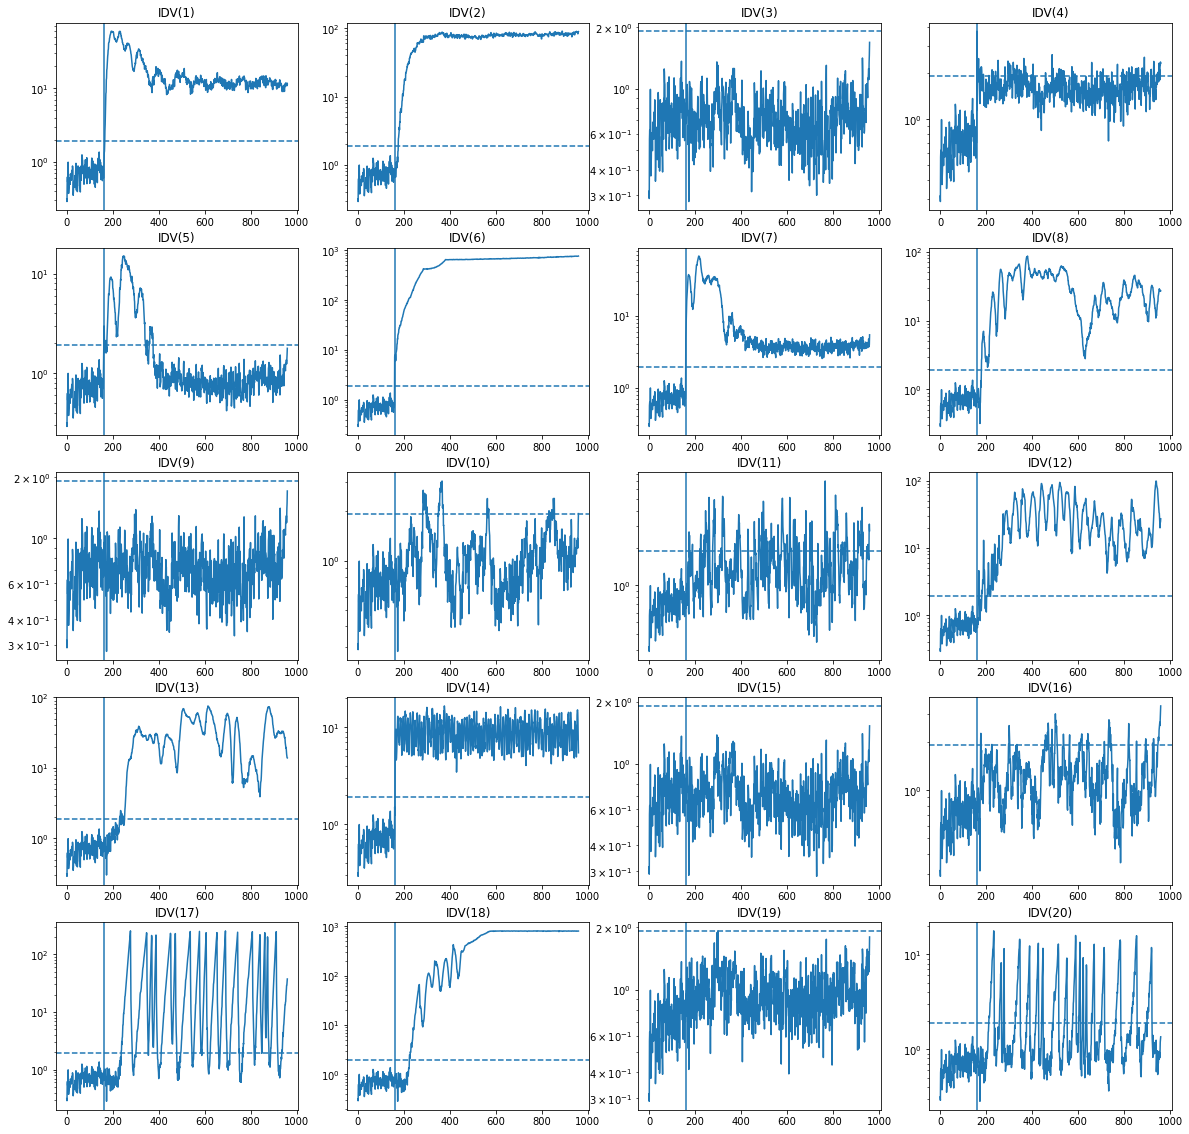

In [12]:
fig, ax = plt.subplots(5,4, figsize = (20, 20))

fdr_df = pd.DataFrame(index=[f'IDV({i})' for i in range(1,21)])

for name, model in models.items():

    spe_test = []
    fdr = []

    for i in range(20):

        df_test = test_faulty[(test_faulty.faultNumber==i+1) & (test_faulty.simulationRun==1)].iloc[:,3:]

        spe_test.append(model.test(df_test))

        fault_occurrence = len(spe_test[i])//6

        fdr.append(np.mean(spe_test[i][fault_occurrence:]>detection_limits[name]))

        color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        ax.ravel()[i].plot(np.arange(len(spe_test[i])), spe_test[i], color = color)
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence)
        ax.ravel()[i].set_title(f'IDV({i+1})')
        ax.ravel()[i].set_yscale('log')
        
    fdr_df[name] = fdr
    
print(100*fdr_df.mean()) # average of the detection error for every type of disturbance   
100*fdr_df.T

## Filter Noise

WS_10     56.66875
WS_50     58.48750
WS_100    59.09375
dtype: float64


,IDV(1),IDV(2),IDV(3),IDV(4),IDV(5),IDV(6),IDV(7),IDV(8),IDV(9),IDV(10),IDV(11),IDV(12),IDV(13),IDV(14),IDV(15),IDV(16),IDV(17),IDV(18),IDV(19),IDV(20)
WS_10,99.00,98.00,0.0,99.625,28.625,99.750,99.625,97.125,0.0,8.500,70.375,98.625,94.250,17.375,0.0,4.5,86.125,92.500,0.125,39.25
WS_50,98.25,96.50,0.0,98.875,97.500,99.000,99.250,95.125,0.0,1.625,64.500,84.750,93.375,0.000,0.0,0.0,89.625,90.875,0.000,60.50
WS_100,98.00,95.75,0.0,98.375,96.750,98.875,99.000,93.625,0.0,0.000,55.500,83.000,92.125,0.000,0.0,0.0,89.500,90.125,0.000,91.25


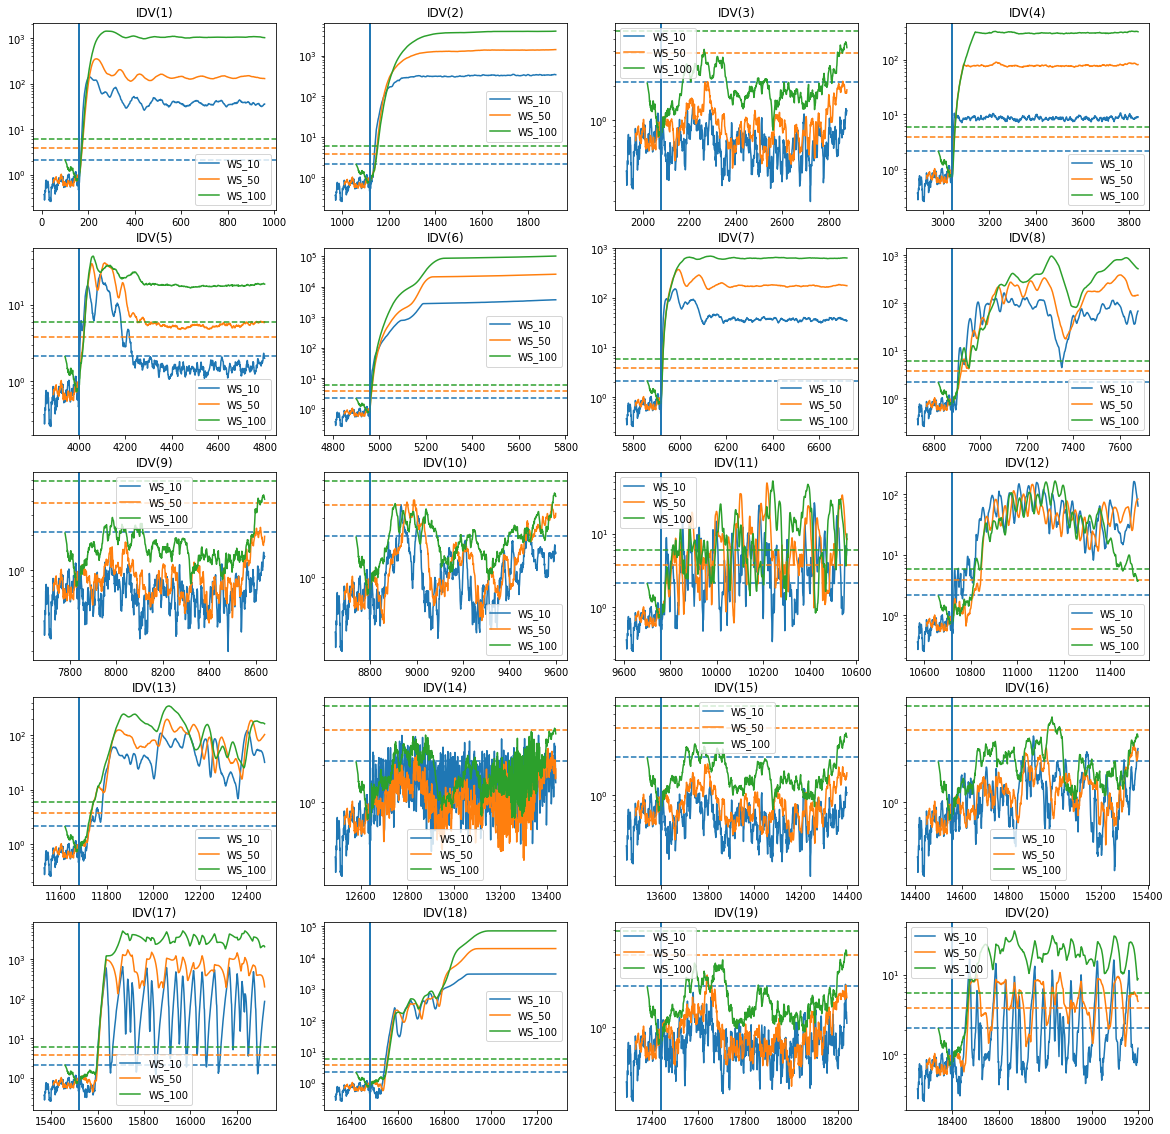

In [13]:
fig, ax = plt.subplots(5,4, figsize = (20, 20))

df_train = train_normal[train_normal.simulationRun==1].iloc[:,3:]
df_validation = train_normal[(train_normal.simulationRun>1)&(train_normal.simulationRun<5)].iloc[:,3:]

models = {'WS_10': ModelEnsembleRegressors(), 'WS_50': ModelEnsembleRegressors(), 'WS_100': ModelEnsembleRegressors()}
WS = {'WS_10': 10, 'WS_50': 50, 'WS_100': 100}

detection_limits = {}

fdr_df = pd.DataFrame(index=[f'IDV({i})' for i in range(1,21)])

for name, model in models.items():

    spe_test = []
    fdr = []
    
    _ = model.train(filter_noise_ma(df_train,WS[name]))
    spe_validation = model.test(filter_noise_ma(df_validation, WS[name]))
    detection_limits[name] = np.percentile(spe_validation, 99.99)

    for i in range(20):
        
        df_test = filter_noise_ma(test_faulty[(test_faulty.faultNumber==i+1) & 
                                                 (test_faulty.simulationRun==1)].iloc[:,3:], WS[name])

        spe_test.append(model.test(df_test))

        fault_occurrence = df_test.index[0]-WS[name]+160

        fdr.append(np.mean(spe_test[i][160-WS[name]:]>detection_limits[name]))

        color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        ax.ravel()[i].plot(df_test.index, spe_test[i], color = color, label=name)
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence)#, color = color)
        ax.ravel()[i].set_title(f'IDV({i+1})')
        ax.ravel()[i].set_yscale('log')
        ax.ravel()[i].legend()
        
    fdr_df[name] = fdr
    
print(100*fdr_df.mean())
100*fdr_df.T